In [14]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [15]:
import ct_projector

In [16]:
# load a sample CT image
filename = '/raid/COVID-19/lung_seg_em/data/medseg/ct/3.nii.gz'
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, x, y, z
img = img[np.newaxis,...].transpose([0,3,2,1])
img = img[..., ::-1]
spacing = np.array(spacing)

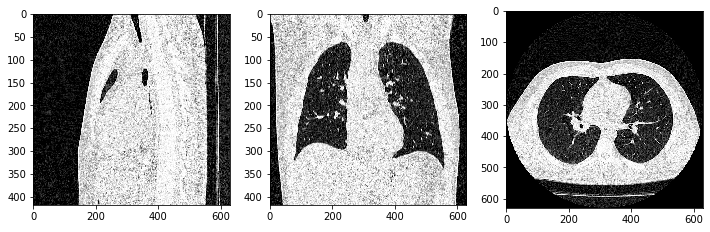

In [17]:
# show the ct images
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0, img.shape[1]//2, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img[0, :, img.shape[2]//2, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img[0, ..., img.shape[3]//2].T, 'gray')

In [18]:
# setup the projector
projector = ct_projector.ct_projector()
projector.from_file('./projector.cfg')
projector.nx = img.shape[1]
projector.ny = img.shape[2]
projector.nz = img.shape[3]
projector.dx = spacing[0]
projector.dy = spacing[1]
projector.dz = spacing[2]

for k in vars(projector):
    print (k, '=', getattr(projector, k))

nview = 2
nu = 2048
nv = 3072
nx = 630
ny = 630
nz = 418
dx = 0.6835939884185791
dy = 0.6835939884185791
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 3000.0
dso = 2700.0
du = 0.25
dv = 0.25
off_u = 0
off_v = 0


In [19]:
# setup the positions of projections, let's do 0, 45, 90, and 135
angles = np.array([0, 45, 90, 135]) * np.pi / 180

srcs = np.array([projector.dso * np.cos(angles), 
                 projector.dso * np.sin(angles), 
                 [0] * len(angles)]).T

det_centers = np.array([(projector.dso - projector.dsd) * np.cos(angles), 
                        (projector.dso - projector.dsd) * np.sin(angles), 
                        [0] * len(angles)]).T

det_us = np.array([-np.sin(angles), np.cos(angles), [0] * len(angles)]).T
det_vs = np.zeros_like(det_us)
det_vs[:, 2] = 1

In [20]:
# very important: use np.copy('C') so that the arrays are saved in C order
img = np.copy(img, 'C')
srcs = np.copy(srcs, 'C')
det_centers = np.copy(det_centers, 'C')
det_us = np.copy(det_us, 'C')
det_vs = np.copy(det_vs, 'C')

In [21]:
# set which device to use
projector.set_device(0)
# forward projection
fp = projector.siddon_cone_fp_abitrary(img, det_centers, det_us, det_vs, srcs)

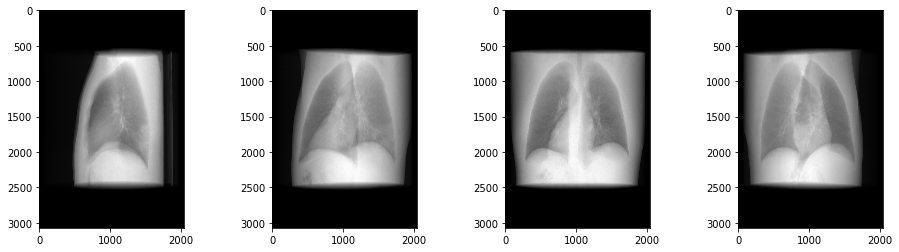

In [23]:
# show the projections
plt.figure(figsize = (16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(fp[0, :, i, :].T, 'gray')

In [30]:
# backprojection: The siddon ray tracing has aliasing when backprojection. Need to be normalized
iangle = 2
bp = projector.siddon_cone_bp_abitrary(np.copy(fp[:, :, [iangle], :], 'C'), 
                                       det_centers[[iangle]], 
                                       det_us[[iangle]], 
                                       det_vs[[iangle]], 
                                       srcs[[iangle]])
bp_norm = projector.siddon_cone_bp_abitrary(np.ones(fp[:, :, [iangle], :].shape, np.float32), 
                                            det_centers[[iangle]], 
                                            det_us[[iangle]], 
                                            det_vs[[iangle]], 
                                            srcs[[iangle]])
bp = bp / (bp_norm + 1e-4)

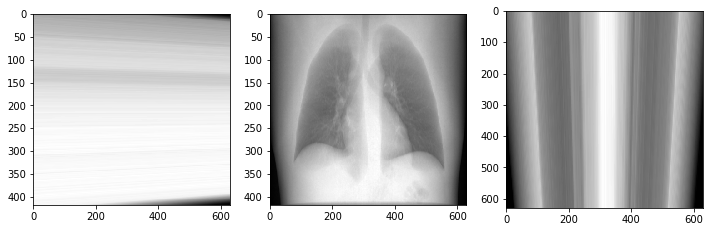

In [31]:
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(bp[0, bp.shape[1]//2, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(bp[0, :, bp.shape[2]//2, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(bp[0, ..., bp.shape[3]//2].T, 'gray')